**SOBRE O CONJUNTO DE DADOS**  
Este conjunto de dados é estruturado para prever a cultura mais adequada para plantio com base em diversos parâmetros agroclimáticos. Ele é tipicamente usado em agricultura de precisão e em aplicações de aprendizado de máquina voltadas a apoiar agricultores, consultores agrícolas e formuladores de políticas.

**Variáveis (Entradas):**
* **N**: Teor de nitrogênio no solo (em mg/kg);
* **P**: Teor de fósforo no solo (em mg/kg);
* **K**: Teor de potássio no solo (em mg/kg);
* **temperature**: Temperatura média em °C;
* **humidity**: Umidade relativa média em %;
* **ph**: Valor de pH do solo;
* **rainfall**: Precipitação pluviométrica em mm.

**Rótulo (Saída):**
* **label** – A cultura mais indicada para as condições dadas (por exemplo: arroz, milho, algodão, etc.).

Texto adaptado do criador do dataset no [Kaggle](https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset).

# PREPARATION, ORGANIZATION, AND STRUCTURING OF DATA
1\. Getting to Know the Dataset  
Inicialmente, podemos verificar o conjunto de dados.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_analytics/crop_recommendation/Crop_recommendation.csv')

df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df.shape

(2200, 8)

Com isso, sabemos que dataset possui 2200 registros e 8 variáveis.

2\. Data type  
Devemos verificar o tipo dos dados e conhecer se os mesmos são passivos de alteração.

In [ ]:
df.dtypes

,0
N,int64
P,int64
K,int64
temperature,float64
humidity,float64
ph,float64
rainfall,float64
label,object


3\. Problematic Values  
Alguns valores podem ser incovenientes à análise de dados, como valores nulos, em branco, incorretos, etc.

In [ ]:
# Null values
df.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


O conjunto de dados não possui valores nulos.

In [ ]:
# Zero values
df.isin([0]).sum()

,0
N,27
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


Assim, conhecemos que o dataset possui 27 valores zero na variável que representa o "teor de nitrogênio no solo". Esses valores terão o devido tratamento posteriormente.

# RANDOM FOREST CLASSIFIER
O Random Forest ajusta vários classificadores de árvore de decisão em diferentes subamostras e utiliza a média para melhorar a precisão preditiva e controlar o sobreajuste. As árvores na "floresta" usam a estratégia de melhor divisão.   
Texto adaptado do site [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

## Data preprocessing
Etapa de preparação dos dados antes de serem usados em um modelo de machine learning.

1\) Zero value treatment  
Assumimos que os valores zero são incoerentes aos dados. Com isso, optamos por utilizar a técnica *K-Nearest Neighbors imputation* para tratar os valores zero no dataset.

In [ ]:
df[df.N == 0].label.unique()

array(['kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'lentil',
       'pomegranate', 'mango', 'grapes', 'apple', 'orange', 'coconut'],
      dtype=object)

É possível conhecer que culturas diferentes possuem zero em sua variável *N*.

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

In [ ]:
df2 = df.copy()

In [ ]:
# Replace 0 with np.nan
df2['N'] = df2.N.replace(0, np.nan)

In [ ]:
# Capturing numerical columns
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
df_numeric = df2[numeric_cols]

In [ ]:
# Replace 0 with NaN in the N variables
df_numeric.loc[:, 'N'] = df_numeric['N'].replace(0, np.nan)

In [ ]:
# Implementing the KNN Imputer Method
imputer = KNNImputer(n_neighbors=2)

In [ ]:
# Applying the Imputer
df_imputed_numeric = imputer.fit_transform(df_numeric)

In [ ]:
# Convert to DataFrame
df_imputed_numeric = pd.DataFrame(df_imputed_numeric, columns=numeric_cols)

In [ ]:
# Replacing numerical columns using the method
df2[numeric_cols] = df_imputed_numeric

In [ ]:
df2['N'] = df2.N.astype('int8')
df2['P'] = df2.P.astype('int8')
df2['K'] = df2.K.astype('int8')

## Model

1\) Class Balancing  
É importante verificar o balanceamento da variável alvo.

In [ ]:
df2.label.nunique()

22

In [ ]:
df2.label.unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

Com isso, percebemos que se trata de um problema multiclasse.

In [ ]:
df2.label.value_counts()

,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


Os reultados mostram que as classes estão equilibradas, o que é bom para a análise.

2\) Variable selection

In [ ]:
X = df2.copy().drop(['label'], axis=1)
y = df2.copy().label

3\) Data split  
Os dados serão divididos em dados de treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Dividir em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

O argumento stratify em y foi utilizado devido ao balanceamento das classes, para que as mesmas permaneçam equilibradas.

4\) Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200], # Number of trees
    'max_depth': [None, 5, 10], # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]
}

In [ ]:
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_

In [ ]:
print(f'Melhores parâmetros: {best_params}')
print(f'Melhor acurácia no CV: {grid_search.best_score_}')

Melhores parâmetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Melhor acurácia no CV: 0.996103896103896


5\) Model implementation

In [ ]:
model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42,
    n_jobs=-1 # Uses all CPU cores
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

## Evaluation
Não basta simplesmente implementar o modelo, é necessário saber se o mesmo é eficiente. Isso pode ser medido através de determinadas métricas.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setting a light background theme
sns.set_theme(style='whitegrid')

plt.rcParams.update({
    'text.color': 'gray',             # text color
    'axes.labelcolor': 'gray',        # axis label color
    'axes.edgecolor': 'gray',         # axis border color
    'xtick.color': 'gray',            # x-axis tick color
    'ytick.color': 'gray',            # y-axis tick color
    'axes.titlecolor': 'gray',        # axis title color
    'axes.edgecolor': 'lightgray',    # axis border color
    'axes.facecolor': 'white',        # axis background color
    'figure.facecolor': 'white',      # figure background color
    'figure.edgecolor': 'white'
    })

### Feature importance
Mede o quanto cada variável contribui para a precisão das previsões. O valor é calculado com base na diminuição média da impureza (como a impureza de Gini) que a variável proporciona ao dividir os dados nas árvores do modelo.

In [ ]:
# Get importances
importances = model.feature_importances_

In [ ]:
# Sort feature importances in descending order
indices = np.argsort(importances)

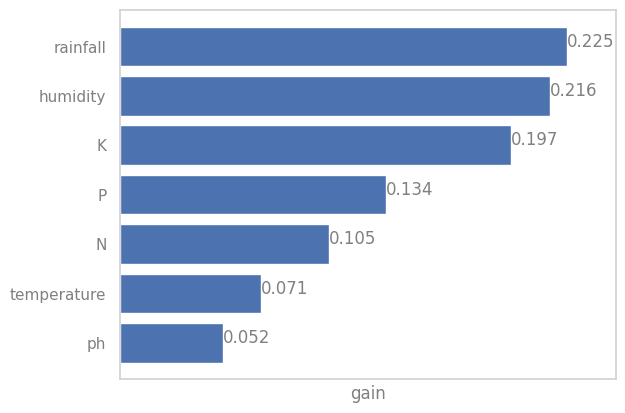

In [ ]:
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])

for i, v in enumerate(importances[indices]):
    plt.text(v, i, f'{v:.3f}')

plt.xlim(0, max(importances[indices]) * 1.11)
plt.xlabel('gain')

plt.grid(False)

plt.xticks([]);

As três variáveis mais importantes, que desempenham um papel maior na previsão da cultura adequada são rainfall (precipitação), humidity (umidade) e k (potássio), que concentram quase 65 % da "força" do modelo. As variáveis com valores mais baixos, como ph e temperature (temperatura), têm menor impacto.

### Confusion matrix-based metrics
Avaliação do desempenho em um limiar específico.

#### Confusion matrix  
Ferramenta que compara as etiquetas verdadeiras com as etiquetas previstas pelo modelo.

In [ ]:
# Predictions
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
model_classes = model.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model_classes)

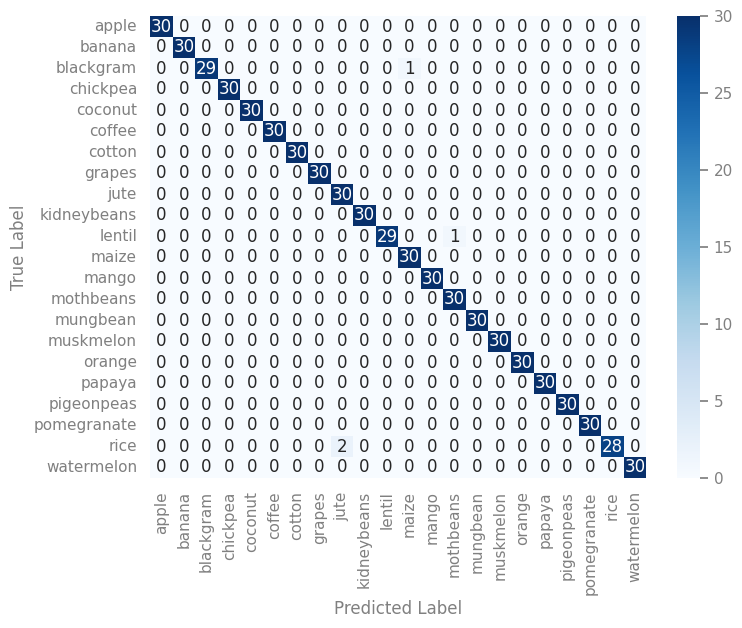

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=model_classes,
    yticklabels=model_classes
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label');

O modelo está praticamente “perfeito” na distinção entre as 22 culturas. Apenas 4 previsões foram mal-sucedidas:
- blackgram: 1 amostra confundida com outra classe;
- lentil: 1 amostra mal classificada;
- rice: 2 amostras confundidas.

Podemos confirmar isso com o seguinte código.

In [ ]:
incorrect_idx = np.where(y_test != y_pred)[0]

# Number of incorrect predictions
len(incorrect_idx)

4

In [ ]:
# Error dataframe
pd.DataFrame({
    'True_Label': y_test.iloc[incorrect_idx].values,
    'Predicted_label': [y_pred[i] for i in incorrect_idx]
}, index=incorrect_idx)

,True_Label,Predicted_label
135,rice,jute
170,rice,jute
263,blackgram,maize
361,lentil,mothbeans


#### Metrics

In [ ]:
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    recall_score,
    f1_score
    )

In [ ]:
dict_class = lambda obj: dict(zip(model_classes, obj))

def cm_metrics(y_true, y_pred, metric, avg=None):
    funcs = {
        'precision': precision_score,
        'recall': recall_score,
        'f1-score': f1_score
    }

    score = funcs[metric](y_true, y_pred, average=avg)

    return dict_class(score) if avg is None else score

1\) Precision  
Proporção de identificações positivas realmente corretas.
<br></br>
$$
\frac{\text{True Positive}}{\text{True Positive}+\text{False Positive}}
$$

In [ ]:
cm_metrics(y_test, y_pred, 'precision', 'macro')

0.9942265395894428

O resultado significa que, mesmo dando o mesmo peso para cada classe (independentemente do número de amostras), o modelo acerta mais de 99% das vezes que faz uma previsão em cada cultura.

In [ ]:
cm_metrics(y_test, y_pred, 'precision')

{'apple': np.float64(1.0),
 'banana': np.float64(1.0),
 'blackgram': np.float64(1.0),
 'chickpea': np.float64(1.0),
 'coconut': np.float64(1.0),
 'coffee': np.float64(1.0),
 'cotton': np.float64(1.0),
 'grapes': np.float64(1.0),
 'jute': np.float64(0.9375),
 'kidneybeans': np.float64(1.0),
 'lentil': np.float64(1.0),
 'maize': np.float64(0.967741935483871),
 'mango': np.float64(1.0),
 'mothbeans': np.float64(0.967741935483871),
 'mungbean': np.float64(1.0),
 'muskmelon': np.float64(1.0),
 'orange': np.float64(1.0),
 'papaya': np.float64(1.0),
 'pigeonpeas': np.float64(1.0),
 'pomegranate': np.float64(1.0),
 'rice': np.float64(1.0),
 'watermelon': np.float64(1.0)}

A maioria das 22 culturas obteve precision de 1.0, ou seja, nenhuma amostra foi incorretamente prevista como pertencente a essas classes. Isso significa que sempre que o modelo "apostou" em apple, banana, coffee, mango etc., por exemplo, ele acertou.  
6,25 % das previsões de jute foram falsos positivos, ou seja, o modelo às vezes rotulou outra cultura como jute. Isso pode estar relacionado a uma confusão com outra cultura, possivelmente devido a características agroclimáticas semelhantes.

2\) Recall  
Proporção de positivos identificados corretamente.
<br></br>
$$
\frac{\text{True Positive}}{\text{True Positive}+\text{False Negative}}
$$

In [ ]:
cm_metrics(y_test, y_pred, 'recall', 'macro')

0.993939393939394

Em média, o modelo identifica corretamente ≈99,4% das amostras reais de cada cultura.

In [ ]:
cm_metrics(y_test, y_pred, 'recall')

{'apple': np.float64(1.0),
 'banana': np.float64(1.0),
 'blackgram': np.float64(0.9666666666666667),
 'chickpea': np.float64(1.0),
 'coconut': np.float64(1.0),
 'coffee': np.float64(1.0),
 'cotton': np.float64(1.0),
 'grapes': np.float64(1.0),
 'jute': np.float64(1.0),
 'kidneybeans': np.float64(1.0),
 'lentil': np.float64(0.9666666666666667),
 'maize': np.float64(1.0),
 'mango': np.float64(1.0),
 'mothbeans': np.float64(1.0),
 'mungbean': np.float64(1.0),
 'muskmelon': np.float64(1.0),
 'orange': np.float64(1.0),
 'papaya': np.float64(1.0),
 'pigeonpeas': np.float64(1.0),
 'pomegranate': np.float64(1.0),
 'rice': np.float64(0.9333333333333333),
 'watermelon': np.float64(1.0)}

Rice apresentou o resultado menos favorável, onde 28/30 amostras reais foram reconhecidas (2 FN).

3\) F1-Score  
Combinação entre Precision e Recall em uma única métrica, considerando ambas igualmente importantes.
<br></br>
$$
2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

In [ ]:
cm_metrics(y_test, y_pred, 'f1-score', 'macro')

0.9939351812060242

O F1-score macro de 0.9939 confirma o altíssimo desempenho geral do modelo, ponderando igualmente precisão e recall em cada classe.

In [ ]:
cm_metrics(y_test, y_pred, 'f1-score')

{'apple': np.float64(1.0),
 'banana': np.float64(1.0),
 'blackgram': np.float64(0.9830508474576272),
 'chickpea': np.float64(1.0),
 'coconut': np.float64(1.0),
 'coffee': np.float64(1.0),
 'cotton': np.float64(1.0),
 'grapes': np.float64(1.0),
 'jute': np.float64(0.967741935483871),
 'kidneybeans': np.float64(1.0),
 'lentil': np.float64(0.9830508474576272),
 'maize': np.float64(0.9836065573770492),
 'mango': np.float64(1.0),
 'mothbeans': np.float64(0.9836065573770492),
 'mungbean': np.float64(1.0),
 'muskmelon': np.float64(1.0),
 'orange': np.float64(1.0),
 'papaya': np.float64(1.0),
 'pigeonpeas': np.float64(1.0),
 'pomegranate': np.float64(1.0),
 'rice': np.float64(0.9655172413793104),
 'watermelon': np.float64(1.0)}

O maior "dreno" de F1 vem dos 2 falsos negativos de rice, que reduzem o recall etambém, jute possui o único caso com falsos positivos, afetando precision. Além disso, blackgram, lentil, maize e mothbeans sofreram 1 falso negativo cada, mantendo precision perfeita mas recall ligeiramente abaixo.

4\) Accuracy  
Mede a proporção de previsões corretas em relação ao total.
<br></br>
$$
\frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}} = \frac{\text{predições corretas}}{\text{todas as predições}}
$$

In [ ]:
accuracy_score(y_test, y_pred)

0.9939393939393939

### ROC-AUC Score
Mede a capacidade do modelo em distinguir entre as classes em diferentes limiares.

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# Probabilistic predictions
y_proba = model.predict_proba(X_test)

Num setup "One-Vs-Rest" (OVR), para cada classe 𝑘, o modelo calcula uma curva ROC comparando Positivos (amostras da classe 𝑘) e Negativos (amostras de todas as outras classes).  
O AUC mede a habilidade de rankear uma amostra positiva (verdadeiro membro de 𝑘) com uma escore de probabilidade maior do que uma amostra negativa.  
O macro-AUC faz a média simples dos AUCs de cada classe, dando peso igual a todas.

In [ ]:
roc_auc_score(y_test, y_proba, average='macro', multi_class='ovr')

np.float64(0.99999518999519)

O resultado corrobora de forma contundente que o modelo quase sempre consegue classificar corretamente amostras de cada cultura (mesmo ao variar o limiar de decisão).

In [ ]:
dict_class(roc_auc_score(y_test, y_proba, average=None, multi_class='ovr'))

{'apple': np.float64(1.0),
 'banana': np.float64(1.0),
 'blackgram': np.float64(0.9998941798941798),
 'chickpea': np.float64(1.0),
 'coconut': np.float64(1.0),
 'coffee': np.float64(1.0),
 'cotton': np.float64(0.9999999999999999),
 'grapes': np.float64(1.0),
 'jute': np.float64(1.0),
 'kidneybeans': np.float64(1.0),
 'lentil': np.float64(1.0),
 'maize': np.float64(1.0),
 'mango': np.float64(1.0),
 'mothbeans': np.float64(1.0),
 'mungbean': np.float64(1.0),
 'muskmelon': np.float64(1.0),
 'orange': np.float64(1.0),
 'papaya': np.float64(1.0),
 'pigeonpeas': np.float64(1.0),
 'pomegranate': np.float64(1.0),
 'rice': np.float64(1.0),
 'watermelon': np.float64(1.0)}

Mesmo resultados diferentes de 1.0, foram praticamente perfeitos, onde a diferença de interpretação pode ser considerada irrelevante na prática.

### Cross-validation
Divide os dados em várias partes para treinar e testar o modelo em diferentes subconjuntos.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
}

In [ ]:
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

In [ ]:
# Remove test_ from the keys of cv_results
cv_result = {k[5:] if 'test_' in k else k: v for k, v in cv_results.items()}

In [ ]:
(
    pd.DataFrame({m: cv_result[m] for m in scoring})
    .agg(['mean', 'std']) # Calculate mean and standard deviation
    .T
)

,mean,std
accuracy,0.995000,0.003371
precision_macro,0.995271,0.003264
recall_macro,0.995000,0.003371
f1_macro,0.994993,0.003374


O desvio-padrão ~0.0033 em todas as métricas mostra mínima variação entre os folds, indicando que o modelo não está "viciando" em nenhum subconjunto específico dos dados.  
Valores médios ≈0.995 implicam que, mesmo em dados nunca vistos, o RF mantém ~99,5% de acurácia e f1_score.

In [ ]:
pd.DataFrame(cv_result, index=[f'Fold {i}' for i in range(5)])

,fit_time,score_time,accuracy,precision_macro,recall_macro,f1_macro
Fold 0,0.709634,0.079664,0.993182,0.993703,0.993182,0.993169
Fold 1,0.679094,0.087577,0.995455,0.995868,0.995455,0.995443
Fold 2,0.656126,0.078860,1.000000,1.000000,1.000000,1.000000
Fold 3,1.025182,0.075306,0.995455,0.995671,0.995455,0.995452
Fold 4,1.117535,0.095921,0.990909,0.991114,0.990909,0.990903


O Fold 2 foi "perfeito". Não obstante, nos outros, há pequenas flutuações, mas sempre acima de 0.99, mas ainda assim excelentes.  
No fit_time, o tempo de treino do modelo varia de ~0.66s a ~1.12s por fold, o que pode ser considerado bom para um RF multiclasses com 22 classes. O score_time conclui um tempo de inferência (predição + cálculo da métrica) estável, em torno de 0.08–0.10s em cada fold.